# Εργασία 2: Αυτόματη διάγνωση σε ιατρικές εικόνες

Πέρα από τα εργαστήρια 2a και 2b, μπορείτε να βρείτε έτοιμο σχετικό κώδικα και εδώ:

https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb

Εγκαθιστούμε τη βιβλιοθήκη `medmnist` στο virtual machine μας. (Χρειάζεται μόνο την πρώτη φορά κάθε session).

In [ ]:
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 3.9 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=d19336dbaf107ec090738a6283f0b6de161f096fc33dbe08a385e0b0119445bc
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


## Εισαγωγή αναγκαίων βιβλιοθηκών και πακέτων
Μπορείτε να επεκτείνετε αυτόν τον κώδικα με ό,τι χρειάζεστε

In [ ]:
from tqdm import tqdm

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.optim import lr_scheduler

import medmnist
from medmnist import INFO
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

print("Pytorch version:", torch.__version__)
print("GPU available:", torch.cuda.is_available())
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

Pytorch version: 1.11.0+cu113
GPU available: True
MedMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/


## Transforms
Θα χρησιμοποιήσουμε τις ίδιες προεπεξεργασίες για όλα τα δεδομένα μας ώστε τα διαφορετικά μοντέλα να είναι συμβατά μεταξύ τους.

Αυτό στηρίζεται στο ότι οι εικόνες των datasets που θα χρησιμοποιήσουμε θα έχουν ίσες διαστάσεις μεταξύ τους (28$\times$28$\times$3)

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ]),
}

## Εισαγωγή του Colon Pathology dataset 

In [ ]:
# Το αντικείμενο medmnist.INFO μανατζάρει όλα τα datasets του medmnist. Με το κλειδί 'pathmnist' (το βρήκαμε στο documentation) επιλέγουμε το Colon Pathology Dataset
path_info = INFO['pathmnist']
path_task = path_info['task']
path_channels = path_info['n_channels']
path_classes = len(path_info['label'])

print ("Οι εικόνες του dataset έχoυν", path_channels, "κανάλια. Ο τύπος προβλήματος είναι", path_task, "ταξινόμηση με", path_classes, "κλάσεις.")

Οι εικόνες του dataset έχoυν 3 κανάλια. Ο τύπος προβλήματος είναι multi-class ταξινόμηση με 9 κλάσεις.


  0%|          | 0/205615438 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
---------------------------------------------------------------------
Διαθέσιμες πληροφορίες για το dataset:
dict_keys(['python_class', 'description', 'url', 'MD5', 'task', 'label', 'n_channels', 'n_samples', 'license'])
Περιγραφή dataset:
The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.
Ερμηνεία labels:
{'0'

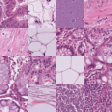

In [ ]:
# Το πεδίο 'python_class' του info επιστρέφει μια κλάση της python που λειτουργεί ως pytorch dataset, για να την περάσουμε στο dataloader
Path_DataClass = getattr(medmnist, path_info['python_class'])

# Φόρτωση (και κατέβασμα) δεδομένων
path_train_dataset = Path_DataClass(split='train', transform=data_transforms['train'], download=True)
path_val_dataset = Path_DataClass(split='val', transform=data_transforms['test'], download=True)
path_test_dataset = Path_DataClass(split='test', transform=data_transforms['test'], download=True)

#Το .info είναι ένα dictionary με επεξηγηματικές πληροφορίες για το dataset
print("---------------------------------------------------------------------")
print("Διαθέσιμες πληροφορίες για το dataset:")
print(path_train_dataset.info.keys())
print("Περιγραφή dataset:")
print(path_train_dataset.info['description'])
print("Ερμηνεία labels:")
print(path_train_dataset.info['label'])

BATCH_SIZE = 128

# encapsulate data into dataloader form
path_train_loader = data.DataLoader(dataset=path_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
path_val_loader = data.DataLoader(dataset=path_val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
path_test_loader = data.DataLoader(dataset=path_val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

print("Δείγμα εικόνων του Colon Pathology dataset:")
path_train_dataset.montage(length=4)



## Δημιουργία μοντέλου

Ο ενδεικτικός κώδικας του MedMNIST προβλέπει τόσο ο αριθμός των καναλιών των εικόνων όσο και ο αριθμός των κλάσεων να εισάγονται ως παράμετροι. Αυτή η ευελιξία δεν μας είναι απαραίτητη καθώς εμείς θα δημιουργήσουμε ένα δίκτυο που θα δέχεται εικόνες 3 καναλιών και θα επιστρέφει 9 κλάσεις, συγκεκριμένα για το PathMNIST. Οποιαδήποτε αλλαγή κάνουμε (π.χ. στον αριθμό των κλάσεων/μονάδων εξόδου) θα γίνει αφού δημιουργήσουμε ένα στιγμιότυπο του ίδιου δικτύου.

Παρόλα αυτά, αν προτιμάτε να τα αφήσετε ως παραμέτρους, μπορείτε.

In [ ]:
import torch.nn as nn


class Net(nn.Module):
    print("Δομή μοντέλου εδώ")
    def __init__(self, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU())

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 3 * 3, 1024),
            nn.ReLU())
        
        self.outputL = nn.Sequential(
            nn.Linear(1024, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.outputL(x)
        return x



net = Net(num_classes=9)

Δομή μοντέλου εδώ


##4. Αξιοποίηση CUDA


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

#Φορτώνουμε το δίκτυο στη GPU
net.to(device)
#Εναλλακτικά net.cuda()

cuda:0


Net(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


##5. Παραμετροποίηση

In [ ]:
print("Λοιπός κώδικας παραμετροποίησης, training, testing κλπ εδώ")

import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

criterion = nn.CrossEntropyLoss()

epochs = 9

Λοιπός κώδικας παραμετροποίησης, training, testing κλπ εδώ


#**6. Training και Test Loop**

## Training Loop

In [ ]:
def train_loop(dataloader, model, criterion, optimizer):
  running_loss = 0.0

  for inputs, targets in tqdm(dataloader):
    # zero the parameter gradients
    optimizer.zero_grad()
  
    # forward + backward + optimize

    #Φορτώνουμε κάθε batch στη GPU
    images = inputs.to(device)
    labels = targets.to(device)
    outputs = model(images)

    t = labels.squeeze().long()
    loss = criterion(outputs, t)
    loss.backward()
    
    #Ο optimizer θα κάνει ένα step για κάθε batch 
    optimizer.step()

    running_loss += loss.item()

  print(f"\nTraining Loss: {running_loss:.3f}")
  print('Finished Training\n')

##Testing Loop

In [ ]:
def test_loop(dataloader, model):
  accuracy = 0.0
  Thetargets =[]
  Theoutputs = []
  with torch.no_grad():
    for inputs, targets in tqdm(dataloader):

      #Φορτώνουμε κάθε batch στη GPU
      images = inputs.to(device)
      labels = targets.to(device)

      outputs = model(images)
      _, preds = torch.max(outputs, 1)

      #Keep all targets and predictions of an epoch in a list in order to use them later in accuracy score
      Thetargets.append(labels.cpu().flatten().tolist())
      
      Theoutputs.append(preds.cpu().flatten().tolist())
      

  #print("Targets:", Thetargets)
  #print("Targets:", np.hstack(Thetargets))
  #print("predictions:" , Theoutputs)
  
  #Χρησιμοποιούμε την μέθοδο accuracy_score από τη βιβλιοθήκη sklearn, η οποία δέχεται όλα τα targets και όλα τα outputs ενός dataset και επιστρέφει το accuracy
  accuracy = accuracy_score(np.hstack(Thetargets), np.hstack(Theoutputs))
  print(f"\nAccuracy: { accuracy:.3f}\n")

######Στην περίπτωση πολύ άνισων κλάσεων, ποιά θα ήταν μια καταλληλότερη μετρική;



> Απάντηση: Στην περίπτωση άνισων κλάσεων θα μπορούσαμε να χρησιμοποιήσουμε είτε precision και recall είτε τον συνδυασμό των δύο παραπάνω, F-measure.



#**7. Εκπαίδευση στο PathMNIST dataset**

In [ ]:
for epoch in range(epochs):
  print(f"Epoch {epoch+1}\n-------------------------------")
  print(f"Training:")
  train_loop(path_train_loader, net, criterion, optimizer)
  
  #O scheduler κάνει ένα step στο τέλος κάθε Epoch 
  scheduler.step()
  
  print(f"Test Loop σε training dataset:")
  test_loop(path_train_loader, net)
  
  print(f"Test Loop σε  validation dataset:")
  test_loop(path_val_loader, net)

print("Done!\n-------------------------------")

print(f"Test Loop σε test dataset:")
test_loop(path_test_loader, net)

Epoch 1
-------------------------------
Training:


100%|██████████| 704/704 [00:32<00:00, 21.94it/s]



Training Loss: 405.400
Finished Training

Test Loop σε training dataset:


100%|██████████| 704/704 [00:23<00:00, 29.52it/s]



Accuracy: 0.870

Test Loop σε  validation dataset:


100%|██████████| 40/40 [00:02<00:00, 16.54it/s]



Accuracy: 0.872

Epoch 2
-------------------------------
Training:


100%|██████████| 704/704 [00:32<00:00, 21.95it/s]



Training Loss: 205.568
Finished Training

Test Loop σε training dataset:


100%|██████████| 704/704 [00:23<00:00, 29.38it/s]



Accuracy: 0.917

Test Loop σε  validation dataset:


100%|██████████| 40/40 [00:02<00:00, 17.54it/s]



Accuracy: 0.919

Epoch 3
-------------------------------
Training:


100%|██████████| 704/704 [00:30<00:00, 22.78it/s]



Training Loss: 150.158
Finished Training

Test Loop σε training dataset:


100%|██████████| 704/704 [00:24<00:00, 29.07it/s]



Accuracy: 0.934

Test Loop σε  validation dataset:


100%|██████████| 40/40 [00:02<00:00, 17.53it/s]



Accuracy: 0.936

Epoch 4
-------------------------------
Training:


100%|██████████| 704/704 [00:31<00:00, 22.65it/s]



Training Loss: 103.685
Finished Training

Test Loop σε training dataset:


100%|██████████| 704/704 [00:24<00:00, 29.19it/s]



Accuracy: 0.954

Test Loop σε  validation dataset:


100%|██████████| 40/40 [00:02<00:00, 17.44it/s]



Accuracy: 0.952

Epoch 5
-------------------------------
Training:


100%|██████████| 704/704 [00:30<00:00, 22.86it/s]



Training Loss: 92.538
Finished Training

Test Loop σε training dataset:


100%|██████████| 704/704 [00:24<00:00, 29.25it/s]



Accuracy: 0.959

Test Loop σε  validation dataset:


100%|██████████| 40/40 [00:02<00:00, 17.02it/s]



Accuracy: 0.958

Epoch 6
-------------------------------
Training:


100%|██████████| 704/704 [00:31<00:00, 22.36it/s]



Training Loss: 84.713
Finished Training

Test Loop σε training dataset:


100%|██████████| 704/704 [00:24<00:00, 29.18it/s]



Accuracy: 0.963

Test Loop σε  validation dataset:


100%|██████████| 40/40 [00:02<00:00, 17.22it/s]



Accuracy: 0.959

Epoch 7
-------------------------------
Training:


100%|██████████| 704/704 [00:30<00:00, 22.91it/s]



Training Loss: 64.841
Finished Training

Test Loop σε training dataset:


100%|██████████| 704/704 [00:23<00:00, 29.38it/s]



Accuracy: 0.971

Test Loop σε  validation dataset:


100%|██████████| 40/40 [00:02<00:00, 17.21it/s]



Accuracy: 0.966

Epoch 8
-------------------------------
Training:


100%|██████████| 704/704 [00:30<00:00, 22.72it/s]



Training Loss: 60.211
Finished Training

Test Loop σε training dataset:


100%|██████████| 704/704 [00:24<00:00, 29.24it/s]



Accuracy: 0.974

Test Loop σε  validation dataset:


100%|██████████| 40/40 [00:02<00:00, 17.48it/s]



Accuracy: 0.968

Epoch 9
-------------------------------
Training:


100%|██████████| 704/704 [00:30<00:00, 22.85it/s]



Training Loss: 55.535
Finished Training

Test Loop σε training dataset:


100%|██████████| 704/704 [00:24<00:00, 29.19it/s]



Accuracy: 0.975

Test Loop σε  validation dataset:


100%|██████████| 40/40 [00:02<00:00, 17.40it/s]



Accuracy: 0.970

Done!
-------------------------------
Test Loop σε test dataset:


100%|██████████| 40/40 [00:02<00:00, 16.58it/s]


Accuracy: 0.970



##**Σχολιασμός**
*Φαίνεται να μαθαίνει το δίκτυο; Βλέπετε συμπτώματα overfitting ή όχι; Από πού θα το συμπεράνετε;*


> Απάντηση: Μπορούμε να παρατηρήσουμε ότι το δίκτυο μας μαθαίνει καθώς απο το 2ο μολις epoch η διαφορά τοσο στο training Loss όσο και στο Accuracy ειναι εμφανής. Επιπλέον, μπορούμε να παρατηρήσουμε την σταθερή και συνεχή αύξηση του accuracy ανα τα epochs φτάνοντας μέχρι και το **0.975** για το **training set** και **0.969** για το **validation set**. Σύμφωνα με τα παραπάνω και γνωρίζοντας ότι το accuracy για το **test set** είναι **0.969** μπορούμε να συμπεράνουμε ότι το δίκτυο μας δεν παρουσιάζει συμπτώματα overfitting.


#**8. Εκπαίδευση με Transfer Learning στο BloodMNIST dataset**

### Εισαγωγή του Blood Cell Microscope dataset 

In [ ]:
data_flag = 'bloodmnist'
download = True

info = INFO[data_flag]
task = info['task']
print (task)
blood_channels = info['n_channels'] # αν τα κανάλια στα inputs είναι διαφορετικά, το transfer learning δεν έχει νόημα γιατί τα δεδομένα δε θα έχουν καμία ομοιότητα
blood_classes = len(info['label'])

Blood_Dataclass = getattr(medmnist, info['python_class'])

multi-class


  0%|          | 0/35461855 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
{'python_class': 'BloodMNIST', 'description': 'The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.', 'url': 'https://zenodo.org/record/6496656/files/bloodmnist.npz?download=1', 'MD5': '7053d0359d879ad8a5505303e11de1dc', 'task': 'multi-class', 'label': {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '

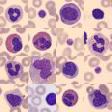

In [ ]:
# load the data
blood_train_dataset = Blood_Dataclass(split='train', transform=data_transforms['train'], download=download)
blood_val_dataset = Blood_Dataclass(split='val', transform=data_transforms['test'], download=download)
blood_test_dataset = Blood_Dataclass(split='test', transform=data_transforms['test'], download=download)
print(blood_test_dataset.info)

# encapsulate data into dataloader form
blood_train_loader = data.DataLoader(dataset=blood_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
blood_val_loader = data.DataLoader(dataset=blood_val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
blood_test_loader = data.DataLoader(dataset=blood_test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

print("Δείγμα εικόνων του Blood Cell Microscope dataset:")
blood_train_dataset.montage(length=4)

In [ ]:
import copy

net2 = Net(num_classes=9)

model_wts = copy.deepcopy(net.state_dict())
net2.load_state_dict(model_wts)

net2.outputL = nn.Linear(1024, 8)
net2.to(device)

optimizer2 = optim.SGD(net2.parameters(), lr=0.005, momentum=0.9)
scheduler2 = lr_scheduler.StepLR(optimizer2, step_size=2, gamma=0.5)

for epoch in range(epochs):
  print(f"Epoch {epoch+1}\n-------------------------------")
  train_loop(blood_train_loader, net2, criterion, optimizer2)
  #O scheduler κάνει ένα step στο τέλος κάθε Epoch 
  scheduler2.step()
  
  print(f"Test Loop σε training dataset: \n")
  test_loop(blood_train_loader, net2)
  print(f"Test Loop σε  validation dataset: \n")
  test_loop(blood_val_loader, net2)

print("Done!")
print(f"Test Loop σε test dataset: \n")
test_loop(blood_test_loader, net2)



Epoch 1
-------------------------------


100%|██████████| 94/94 [00:04<00:00, 21.54it/s]



Training Loss: 62.571
Finished Training

Test Loop σε training dataset: 



100%|██████████| 94/94 [00:03<00:00, 29.94it/s]



Accuracy: 0.874

Test Loop σε  validation dataset: 



100%|██████████| 7/7 [00:00<00:00, 17.10it/s]



Accuracy: 0.877

Epoch 2
-------------------------------


100%|██████████| 94/94 [00:04<00:00, 21.95it/s]



Training Loss: 26.273
Finished Training

Test Loop σε training dataset: 



100%|██████████| 94/94 [00:03<00:00, 29.16it/s]



Accuracy: 0.916

Test Loop σε  validation dataset: 



100%|██████████| 7/7 [00:00<00:00, 17.78it/s]



Accuracy: 0.913

Epoch 3
-------------------------------


100%|██████████| 94/94 [00:04<00:00, 21.94it/s]



Training Loss: 19.484
Finished Training

Test Loop σε training dataset: 



100%|██████████| 94/94 [00:03<00:00, 29.93it/s]



Accuracy: 0.927

Test Loop σε  validation dataset: 



100%|██████████| 7/7 [00:00<00:00, 17.63it/s]



Accuracy: 0.928

Epoch 4
-------------------------------


100%|██████████| 94/94 [00:04<00:00, 22.41it/s]



Training Loss: 17.325
Finished Training

Test Loop σε training dataset: 



100%|██████████| 94/94 [00:03<00:00, 30.09it/s]



Accuracy: 0.937

Test Loop σε  validation dataset: 



100%|██████████| 7/7 [00:00<00:00, 17.36it/s]



Accuracy: 0.932

Epoch 5
-------------------------------


100%|██████████| 94/94 [00:04<00:00, 22.18it/s]



Training Loss: 15.182
Finished Training

Test Loop σε training dataset: 



100%|██████████| 94/94 [00:03<00:00, 30.65it/s]



Accuracy: 0.952

Test Loop σε  validation dataset: 



100%|██████████| 7/7 [00:00<00:00, 17.92it/s]



Accuracy: 0.941

Epoch 6
-------------------------------


100%|██████████| 94/94 [00:04<00:00, 22.12it/s]



Training Loss: 13.888
Finished Training

Test Loop σε training dataset: 



100%|██████████| 94/94 [00:03<00:00, 29.85it/s]



Accuracy: 0.955

Test Loop σε  validation dataset: 



100%|██████████| 7/7 [00:00<00:00, 17.88it/s]



Accuracy: 0.943

Epoch 7
-------------------------------


100%|██████████| 94/94 [00:04<00:00, 22.24it/s]



Training Loss: 12.483
Finished Training

Test Loop σε training dataset: 



100%|██████████| 94/94 [00:03<00:00, 30.48it/s]



Accuracy: 0.958

Test Loop σε  validation dataset: 



100%|██████████| 7/7 [00:00<00:00, 17.17it/s]



Accuracy: 0.946

Epoch 8
-------------------------------


100%|██████████| 94/94 [00:04<00:00, 22.14it/s]



Training Loss: 12.201
Finished Training

Test Loop σε training dataset: 



100%|██████████| 94/94 [00:03<00:00, 29.77it/s]



Accuracy: 0.959

Test Loop σε  validation dataset: 



100%|██████████| 7/7 [00:00<00:00, 17.94it/s]



Accuracy: 0.950

Epoch 9
-------------------------------


100%|██████████| 94/94 [00:04<00:00, 21.85it/s]



Training Loss: 11.670
Finished Training

Test Loop σε training dataset: 



100%|██████████| 94/94 [00:03<00:00, 30.47it/s]



Accuracy: 0.961

Test Loop σε  validation dataset: 



100%|██████████| 7/7 [00:00<00:00, 17.87it/s]



Accuracy: 0.946

Done!
Test Loop σε test dataset: 



100%|██████████| 14/14 [00:00<00:00, 17.92it/s]


Accuracy: 0.946



#**9. Εκπαίδευση χωρίς Transfer Learning στο BloodMNIST dataset**

In [ ]:
net3 = Net(num_classes=8)


optimizer3 = optim.SGD(net3.parameters(), lr=0.005, momentum=0.9)
scheduler3 = lr_scheduler.StepLR(optimizer3, step_size=2, gamma=0.5)
net3.to(device)

for epoch in range(epochs):
  print(f"Epoch {epoch+1}\n-------------------------------")
  train_loop(blood_train_loader, net3, criterion, optimizer3)
  #O scheduler κάνει ένα step στο τέλος κάθε Epoch 
  scheduler3.step()
  
  print(f"Test Loop σε training dataset: \n")
  test_loop(blood_train_loader, net3)
  print(f"Test Loop σε  validation dataset: \n")
  test_loop(blood_val_loader, net3)

print("Done!")
print(f"Test Loop σε test dataset: \n")
test_loop(blood_test_loader, net3)


Epoch 1
-------------------------------


100%|██████████| 94/94 [00:04<00:00, 22.09it/s]



Training Loss: 69.397
Finished Training

Test Loop σε training dataset: 



100%|██████████| 94/94 [00:03<00:00, 30.52it/s]



Accuracy: 0.875

Test Loop σε  validation dataset: 



100%|██████████| 7/7 [00:00<00:00, 18.01it/s]



Accuracy: 0.877

Epoch 2
-------------------------------


100%|██████████| 94/94 [00:04<00:00, 22.43it/s]



Training Loss: 30.609
Finished Training

Test Loop σε training dataset: 



100%|██████████| 94/94 [00:03<00:00, 30.85it/s]



Accuracy: 0.902

Test Loop σε  validation dataset: 



100%|██████████| 7/7 [00:00<00:00, 17.40it/s]



Accuracy: 0.900

Epoch 3
-------------------------------


100%|██████████| 94/94 [00:04<00:00, 22.52it/s]



Training Loss: 21.992
Finished Training

Test Loop σε training dataset: 



100%|██████████| 94/94 [00:03<00:00, 30.48it/s]



Accuracy: 0.936

Test Loop σε  validation dataset: 



100%|██████████| 7/7 [00:00<00:00, 18.42it/s]



Accuracy: 0.935

Epoch 4
-------------------------------


100%|██████████| 94/94 [00:04<00:00, 22.56it/s]



Training Loss: 19.066
Finished Training

Test Loop σε training dataset: 



100%|██████████| 94/94 [00:03<00:00, 29.97it/s]



Accuracy: 0.944

Test Loop σε  validation dataset: 



100%|██████████| 7/7 [00:00<00:00, 17.58it/s]



Accuracy: 0.937

Epoch 5
-------------------------------


100%|██████████| 94/94 [00:04<00:00, 22.33it/s]



Training Loss: 14.822
Finished Training

Test Loop σε training dataset: 



100%|██████████| 94/94 [00:03<00:00, 30.07it/s]



Accuracy: 0.955

Test Loop σε  validation dataset: 



100%|██████████| 7/7 [00:00<00:00, 17.92it/s]



Accuracy: 0.946

Epoch 6
-------------------------------


100%|██████████| 94/94 [00:04<00:00, 22.06it/s]



Training Loss: 13.709
Finished Training

Test Loop σε training dataset: 



100%|██████████| 94/94 [00:03<00:00, 30.41it/s]



Accuracy: 0.960

Test Loop σε  validation dataset: 



100%|██████████| 7/7 [00:00<00:00, 18.14it/s]



Accuracy: 0.948

Epoch 7
-------------------------------


100%|██████████| 94/94 [00:04<00:00, 22.21it/s]



Training Loss: 11.742
Finished Training

Test Loop σε training dataset: 



100%|██████████| 94/94 [00:03<00:00, 30.66it/s]



Accuracy: 0.961

Test Loop σε  validation dataset: 



100%|██████████| 7/7 [00:00<00:00, 18.32it/s]



Accuracy: 0.945

Epoch 8
-------------------------------


100%|██████████| 94/94 [00:04<00:00, 22.17it/s]



Training Loss: 11.112
Finished Training

Test Loop σε training dataset: 



100%|██████████| 94/94 [00:03<00:00, 29.87it/s]



Accuracy: 0.965

Test Loop σε  validation dataset: 



100%|██████████| 7/7 [00:00<00:00, 17.31it/s]



Accuracy: 0.952

Epoch 9
-------------------------------


100%|██████████| 94/94 [00:04<00:00, 22.01it/s]



Training Loss: 10.187
Finished Training

Test Loop σε training dataset: 



100%|██████████| 94/94 [00:03<00:00, 29.96it/s]



Accuracy: 0.970

Test Loop σε  validation dataset: 



100%|██████████| 7/7 [00:00<00:00, 17.26it/s]



Accuracy: 0.953

Done!
Test Loop σε test dataset: 



100%|██████████| 14/14 [00:00<00:00, 17.89it/s]


Accuracy: 0.944



##**Σχολιασμός:**
*Φαίνεται να μαθαίνει το δίκτυο; Φαίνεται να πάσχει 
από overfitting; Συμπεραίνετε ότι το Transfer Learning συνεισέφερε κάτι μεταξύ των δύο datasets*


Αρχικά, όσον αφορά το **Transfer Learning**, παρατηρήσαμε ότι η μεταφορά των βαρών από το προηγούμενο εκπαιδευμένο δίκτυο επέφερε εμφανή βελτίωση στην εκπαίδευση του νέου δικτύου καθώς απο το 2ο epoch η διαφορά που υπάρχει στις μετρικές είναι εμφανής σε σχέση με πριν.

Όσον αφορά, το παραπάνω δίκτυο (**net3**) παρατηρούμε ότι συνεχώς μαθαίνει καθώς υπάρχει **συνεχής βελτίωση** ανα τα epochs τόσο στο Training Loss όσο και στο Accuracy.

Επιπλέον, το δίκτυο μας **δεν φαίνεται να πάσχει από overfitting** καθώς το **Accuracy** του test set είναι στο **0.947** πράγμα που σημαίνει ότι το δικτυό μας καταφέρνει να γενικεύει και να επιστρέφει σωστές κλάσεις για τα άγνωστα αντικέιμενα που βλέπει για πρώτη φορά. 
